# Estimating COVID-19's $R_t$ in Real-Time - MCMC
Kevin Systrom - April 12

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import pymc3 as pm

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

In [4]:
state_name = 'New York'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

In [5]:
original = original.clip(1)

<BarContainer object of 48 artists>

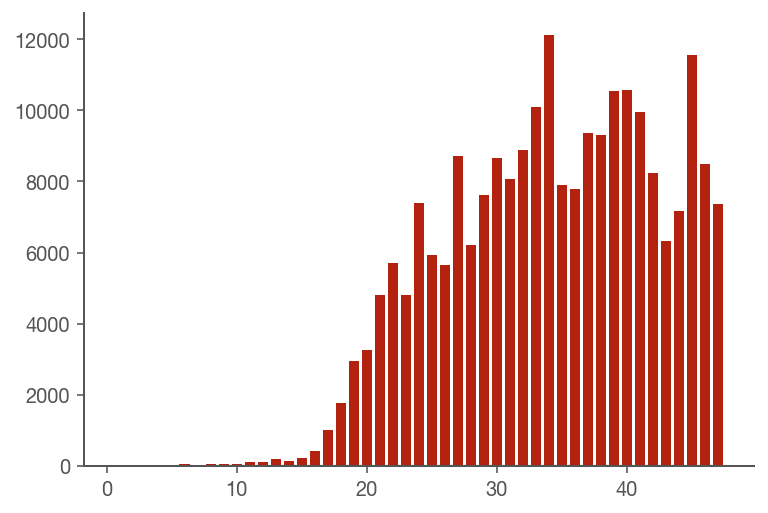

In [6]:
plt.bar(range(len(original)),original)

In [7]:
smoothed = smoothed.iloc[10:]

<BarContainer object of 38 artists>

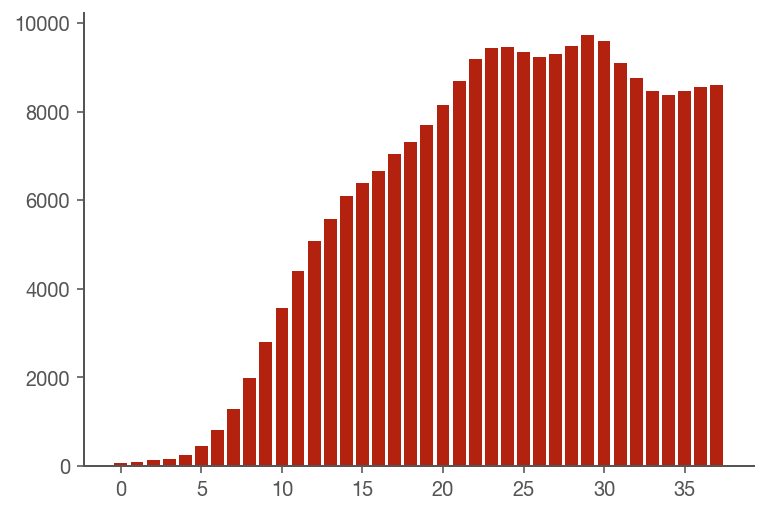

In [8]:
plt.bar(range(len(smoothed)),smoothed)

In [9]:
def lambda_of_rt(Rt, k, γ=1./7):
    k_tm1 = k.iloc[:-1].values
    return k_tm1 * pm.math.exp(γ*(Rt-1))

In [10]:
with pm.Model() as model:
    step_width = pm.HalfNormal('step_width', sigma=0.1)
    
    shape = (len(smoothed)-1,)
    Rt = pm.GaussianRandomWalk('Rt',
                               mu=0,
                               sigma=step_width,
                               shape=shape,
                               testval=np.full(shape, 3))
    
    lam = pm.Deterministic('lam', lambda_of_rt(Rt, smoothed))
    
    pm.Poisson('obs', lam, observed=smoothed.iloc[1:].values)
    
    trace = pm.sample(cores=4, tune=100, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rt, step_width]
Sampling 4 chains, 0 divergences: 100%|██████████| 2400/2400 [00:03<00:00, 616.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


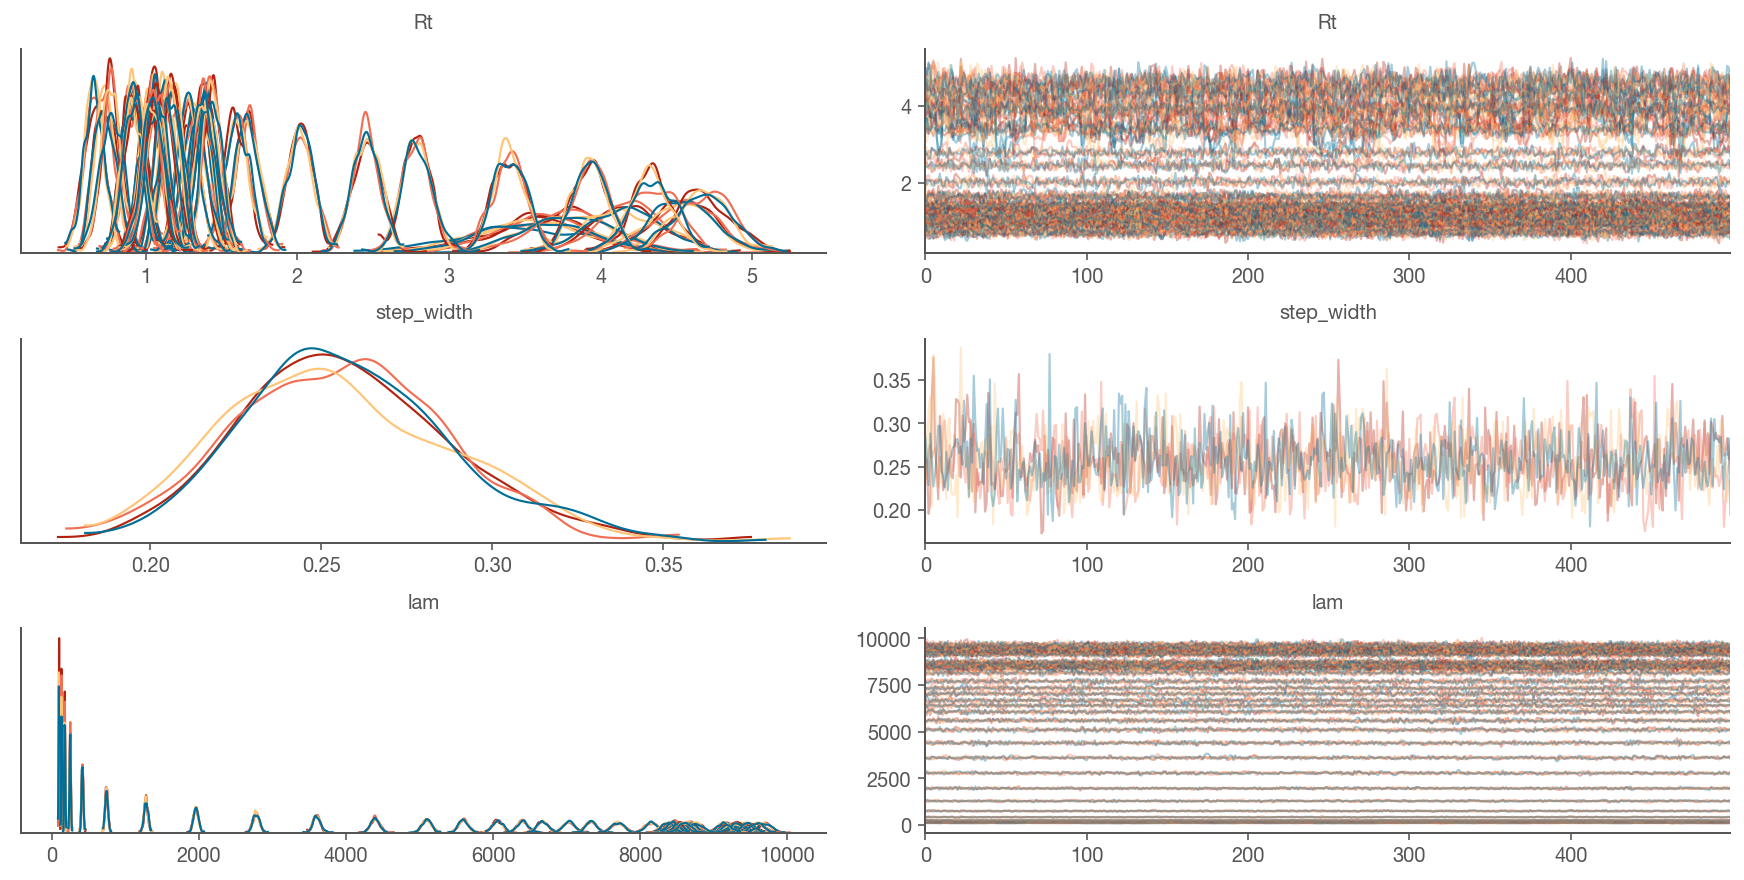

In [12]:
pm.traceplot(trace);

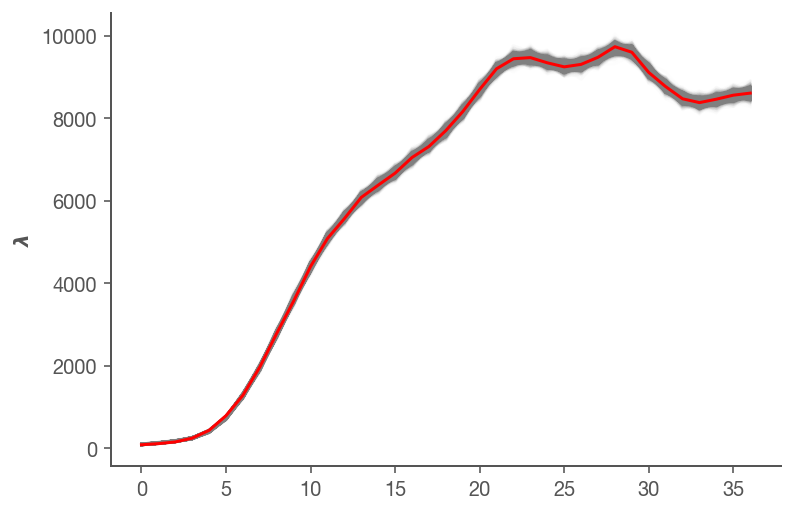

In [13]:
plt.plot(trace['lam'].T, alpha=.01, color='0.5')
plt.plot(smoothed.values[1:], color='r')
plt.ylabel('$\lambda$');

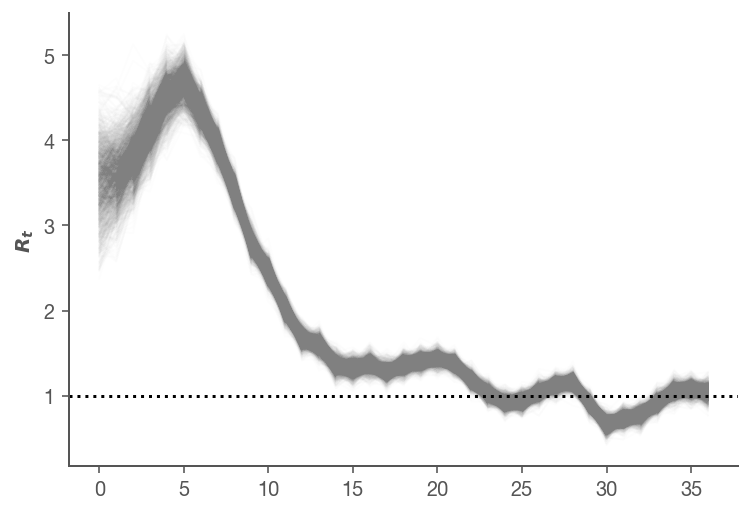

In [14]:
fig, ax = plt.subplots()

ax.plot(trace['Rt'].T, alpha=.01, color='.5', lw=1);
ax.set_ylabel('$R_{t}$');
# ax.set_ylim(.8, 1.3)
ax.axhline(1.0, c='k', linestyle=":")